---
title: "Stock Management Unit Profiles"
format: 
  html:
    css: ../assets/css/smu_profiles.css
    toc: true
    toc-depth: 2
    code-fold: true
execute:
  echo: false
  warning: false
  message: false
jupyter: python3
---

In [1]:
import pandas as pd
import numpy as np
from IPython.display import HTML, display
import json

# Read the Excel file
try:
    import os
    file_path = '../assets/data/smu_profiles.xlsx'
    # print(f"Attempting to read file: {file_path}")
    # print(f"File exists: {os.path.exists(file_path)}")
    # print(f"File is readable: {os.access(file_path, os.R_OK)}")
    
    df = pd.read_excel(file_path)
    # print(f"Successfully loaded {len(df)} SMU records")
except PermissionError as e:
    # print(f"Permission error: {e}")
    # print("The file might be open in Excel or another application.")
    # print("Attempting to read with alternative method...")
    try:
        # Try reading with openpyxl engine explicitly
        df = pd.read_excel(file_path, engine='openpyxl')
        # print(f"Successfully loaded {len(df)} SMU records using alternative method")
    except Exception as e2:
        # print(f"Alternative method also failed: {e2}")
        df = pd.DataFrame()
except FileNotFoundError as e:
    # print(f"File not found: {e}")
    df = pd.DataFrame()
except Exception as e:
    # print(f"Error loading data: {e}")
    # print(f"Error type: {type(e).__name__}")
    df = pd.DataFrame()

## Overview

This page contains profiles of **{{< meta title >}}** for Pacific salmon conservation. The data includes information on `{python} len(df) if not df.empty else 0` stock management units.

In [2]:
#| output: asis

# if not df.empty:
#     # Clean up the data
#     df = df.fillna('N/A')
    
#     # Get summary statistics
#     species_counts = df['species'].value_counts() if 'species' in df.columns else pd.Series()
    
#     print("### Data Summary")
#     print(f"- **Total SMUs:** {len(df)}")
#     if not species_counts.empty:
#         print(f"- **Species represented:** {len(species_counts)}")
#         for species, count in species_counts.head(5).items():
#             print(f"  - {species}: {count} SMUs")
# else:
#     print("No data available.")

## Search and Filter

In [3]:
from IPython.display import HTML

# Always display search controls, even if no data
display(HTML("""
<div class="search-controls">
    <input type="text" id="searchInput" placeholder="Search SMUs..." onkeyup="filterTable()">
    <select id="speciesFilter" onchange="filterTable()">
        <option value="">All Species</option>
    </select>
    <select id="regionFilter" onchange="filterTable()">
        <option value="">All Regions</option>
    </select>
</div>
"""))

if df.empty:
    display(HTML("""
    <p>No data to display.</p>
    <div class="table-wrapper" style="display: none;">
        <table id="smuTable" class="display-table">
            <thead><tr><th>No Data</th></tr></thead>
            <tbody></tbody>
        </table>
    </div>
    """))

## SMU Data Table
###### Click each row to view details

In [4]:
if not df.empty:
    # Select key columns for the main table
    display_columns = []
    possible_columns = [
        'SMU Name', 'Species', 'Region', 
        'No. CUs', 'SMU Status',
        'Avg. Abundance', 'Avg. Catch', 'Avg. ER'
    ]
    
    for col in possible_columns:
        if col in df.columns:
            display_columns.append(col)
    
    if display_columns:
        display_df = df[display_columns].copy()
        
        # Debug: print column info
        # print(f"Display columns: {display_columns}")
        # print(f"Data shape: {display_df.shape}")
        
        # Create HTML table with proper styling and IDs
        html_table = '<div class="table-wrapper">\n'
        html_table += '<table id="smuTable" class="display-table">\n'
        html_table += '<thead>\n<tr>\n'
        
        for col in display_columns:
            html_table += f'<th>{col}</th>\n'
        html_table += '</tr>\n</thead>\n<tbody>\n'
        
        for idx, row in display_df.iterrows():
            html_table += f'<tr onclick="showDetails({idx})" class="clickable-row">\n'
            for col in display_columns:
                # Escape HTML characters and handle NaN values
                value = str(row[col]) if pd.notna(row[col]) else 'N/A'
                # Basic HTML escaping
                value = value.replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;').replace('"', '&quot;')
                html_table += f'<td>{value}</td>\n'
            html_table += '</tr>\n'
        
        html_table += '</tbody>\n</table>\n</div>'
        
        # Debug: print first few characters of HTML
        # print(f"HTML table preview: {html_table[:200]}...")
        
        display(HTML(html_table))
    else:
        display(HTML("<p>No suitable columns found for display.</p>"))
else:
    display(HTML("<p>No data to display.</p>"))

SMU Name,Species,Region,SMU Status,Avg. Abundance,Avg. Catch,Avg. ER
ALSEK CHINOOK SALMON,Chinook,YUKON TRANSBOUNDARY,N/A,N/A,N/A,N/A
ALSEK COHO SALMON,Coho,YUKON TRANSBOUNDARY,N/A,N/A,N/A,N/A
ALSEK SOCKEYE SALMON,Sockeye,YUKON TRANSBOUNDARY,N/A,N/A,N/A,N/A
CENTRAL COAST CHINOOK SALMON,Chinook,NORTH COAST,Uncertain,N/A,N/A,Atnarko: 0.45
CENTRAL COAST CHUM SALMON,Chum,NORTH COAST,N/A,N/A,N/A,0.4
CENTRAL COAST COHO SALMON,Coho,NORTH COAST,Uncertain,N/A,N/A,0.1
CENTRAL COAST PINK SALMON,Pink,NORTH COAST,N/A,N/A,N/A,0.2
CENTRAL COAST SOCKEYE SALMON,Sockeye,NORTH COAST,N/A,N/A,N/A,N/A
ECVI/MAINLAND PINK SALMON - EVEN,Pink,SOUTH COAST,N/A,N/A,N/A,N/A
ECVI/MAINLAND PINK SALMON - ODD,Pink,SOUTH COAST,N/A,N/A,N/A,N/A


In [5]:
# Always display the detail view HTML elements
display(HTML('''
<div id="detailView" style="display: none;">
    <button onclick="hideDetails()" class="back-button">← Back to Table</button>
    <div id="detailContent"></div>
</div>
'''))

In [6]:
# Create JavaScript data object - always define, even if empty
import json

if not df.empty:
    df_json = df.to_json(orient='records')
    columns_list = json.dumps(list(df.columns))
else:
    df_json = "[]"
    columns_list = "[]"

js_code = f"""
<script>
const smuData = {df_json};
const allColumns = {columns_list};

// Populate species and region filters
window.addEventListener('DOMContentLoaded', function() {{
    const speciesFilter = document.getElementById('speciesFilter');
    const regionFilter = document.getElementById('regionFilter');
    
    if (speciesFilter && smuData && smuData.length > 0) {{
        const species = [...new Set(smuData.map(item => item.Species || item.species).filter(s => s && s !== 'N/A'))].sort();
        species.forEach(s => {{
            const option = document.createElement('option');
            option.value = s;
            option.textContent = s;
            speciesFilter.appendChild(option);
        }});
    }}
    
    if (regionFilter && smuData && smuData.length > 0) {{
        const regions = [...new Set(smuData.map(item => item.Region || item.region).filter(r => r && r !== 'N/A'))].sort();
        regions.forEach(r => {{
            const option = document.createElement('option');
            option.value = r;
            option.textContent = r;
            regionFilter.appendChild(option);
        }});
    }}
}});

function filterTable() {{
    const searchTerm = document.getElementById('searchInput').value.toLowerCase();
    const speciesFilter = document.getElementById('speciesFilter').value;
    const regionFilter = document.getElementById('regionFilter').value;
    const table = document.getElementById('smuTable');
    const rows = table.getElementsByTagName('tr');
    
    // Get column indices for Species and Region
    const headerRow = table.getElementsByTagName('tr')[0];
    const headers = Array.from(headerRow.getElementsByTagName('th')).map(th => th.textContent);
    const speciesIndex = headers.findIndex(h => h === 'Species' || h === 'species');
    const regionIndex = headers.findIndex(h => h === 'Region' || h === 'region');
    
    for (let i = 1; i < rows.length; i++) {{
        const row = rows[i];
        const cells = row.getElementsByTagName('td');
        let showRow = true;
        
        // Search filter
        if (searchTerm) {{
            let found = false;
            for (let j = 0; j < cells.length; j++) {{
                if (cells[j].textContent.toLowerCase().includes(searchTerm)) {{
                    found = true;
                    break;
                }}
            }}
            if (!found) showRow = false;
        }}
        
        // Species filter
        if (speciesFilter && speciesIndex >= 0 && cells.length > speciesIndex) {{
            if (cells[speciesIndex].textContent !== speciesFilter) {{
                showRow = false;
            }}
        }}
        
        // Region filter
        if (regionFilter && regionIndex >= 0 && cells.length > regionIndex) {{
            if (cells[regionIndex].textContent !== regionFilter) {{
                showRow = false;
            }}
        }}
        
        row.style.display = showRow ? '' : 'none';
    }}
}}

function showDetails(index) {{
    // Safety checks
    if (!smuData || smuData.length === 0 || index >= smuData.length || index < 0) {{
        console.error('Invalid data or index for showDetails');
        return;
    }}
    
    const smu = smuData[index];
    const detailView = document.getElementById('detailView');
    const detailContent = document.getElementById('detailContent');
    const table = document.getElementById('smuTable');
    
    if (!smu || !detailView || !detailContent) return;
    
    let html = `<h2>${{smu['SMU Name'] || 'SMU Profile'}}</h2>`;
    
    // Basic Information
    html += '<div class="detail-section"><h3><i>Basic Information</i></h3><div class="info-grid">';
    const basicFields = ['Species', 'Region', 'No. CUs', 'Avg. Abundance', 'Avg. Catch', 'Avg. ER', 'SMU Status', 'PST Chapter', 'FN Treaty', 'FSP Batch Status'];
         basicFields.forEach(field => {{
         if (allColumns.includes(field)) {{
             html += `<div class="info-item"><label>${{field}}:</label><span>${{smu[field] || 'N/A'}}</span></div>`;
         }}
     }});
    html += '</div><br></div>';
    
    // Life History
    html += '<div class="detail-section"><h3><i>Life History</i></h3><div class="info-grid">';
    const popFields = ['Run Timing', 'Freshwater Life History', 'Ocean Migration', 'Age at Return'];
         popFields.forEach(field => {{
         if (allColumns.includes(field)) {{
             html += `<div class="info-item"><label>${{field}}:</label><span>${{smu[field] || 'N/A'}}</span></div>`;
         }}
     }});
    html += '</div><br></div>';
    
    // Management & Harvest
    html += '<div class="detail-section"><h3><i>Management & Harvest</i></h3><div class="info-grid">';
    const mgmtFields = ['Harvest Control Rules', 'Hatchery Management Framework', 'Sampling Framework'];
         mgmtFields.forEach(field => {{
         if (allColumns.includes(field)) {{
             html += `<div class="info-item"><label>${{field}}:</label><span>${{smu[field] || 'N/A'}}</span></div>`;
         }}
     }});
    html += '</div><br></div>';
    
    // Reference Points
    html += '<div class="detail-section"><h3><i>Reference Points</i></h3><div class="info-grid">';
    const addFields = ['LRP', 'USR', 'RR', 'FRP-L', 'FRP-U'];
         addFields.forEach(field => {{
         if (allColumns.includes(field)) {{
             html += `<div class="info-item"><label>${{field}}:</label><span>${{smu[field] || 'N/A'}}</span></div>`;
         }}
     }});
    html += '</div><br></div>';

         //Data Collected
     html += '<div class="detail-section"><h3><i>Data Collected</i></h3>';
     html += '<table class="data-collected-table">';
     html += '<tbody>';
     for (let i = 0; i < 3; i++) {{
         html += '<tr>';
         for (let j = 0; j < 5; j++) {{
             html += '<td>&nbsp;</td>';
         }}
         html += '</tr>';
     }}
     html += '</tbody>';
     html += '</table>';
     html += '</div>';
    
    // FSAR Assessment
    if (smu['FSAR - last assessment'] && smu['FSAR - last assessment'] !== 'N/A') {{
        html += '<div class="detail-section"><h3><i>FSAR Assessment</i></h3>';
        html += `<p><strong>Last Assessment:</strong> <a href="#" target="_blank" rel="noopener noreferrer">${{smu['FSAR - last assessment']}}</a></p>`;
        html += '</div>';
    }}

         // Maps
     html += '<div class="detail-section"><h3><i>Maps</i></h3>';
     html += '<div class="maps-container">';
     const mapTypes = ['FW Spawning', 'Marine Distribution', 'Fishery Impacts'];
     mapTypes.forEach(mapType => {{
         html += `<div class="map-item">`;
         html += `<h4>${{mapType}}</h4>`;
         html += `<div class="map-placeholder">`;
         html += `<div class="map-placeholder-content">`;
         html += `<p>Map Placeholder</p>`;
         html += `<p>${{mapType}} map will be displayed here</p>`;
         html += `</div></div></div>`;
     }});
     html += '</div></div>';
    
    detailContent.innerHTML = html;
    document.querySelector('.table-wrapper').style.display = 'none';
    document.querySelector('.search-controls').style.display = 'none';
    detailView.style.display = 'block';
}}

function hideDetails() {{
    const detailView = document.getElementById('detailView');
    const tableWrapper = document.querySelector('.table-wrapper');
    const searchControls = document.querySelector('.search-controls');
    
    if (detailView) detailView.style.display = 'none';
    if (tableWrapper) tableWrapper.style.display = 'block';
    if (searchControls) searchControls.style.display = 'flex';
}}
</script>
    """

display(HTML(js_code))

## Data Export

In [7]:
if not df.empty:
    display(HTML("""
<div class="export-section">
    <h3>Export Data</h3>
    <button onclick="exportToCSV()" class="export-button">Download as CSV</button>
</div>

<script>
function exportToCSV() {
    const headers = allColumns;
    let csvContent = headers.join(',') + '\\n';
    
    smuData.forEach(row => {
        const values = headers.map(header => {
            const value = row[header] || '';
            return '"' + String(value).replace(/"/g, '""') + '"';
        });
        csvContent += values.join(',') + '\\n';
    });
    
    const blob = new Blob([csvContent], { type: 'text/csv' });
    const url = window.URL.createObjectURL(blob);
    const a = document.createElement('a');
    a.href = url;
    a.download = 'smu_profiles.csv';
    document.body.appendChild(a);
    a.click();
    document.body.removeChild(a);
    window.URL.revokeObjectURL(url);
}
</script>
    """))

## Summary Statistics

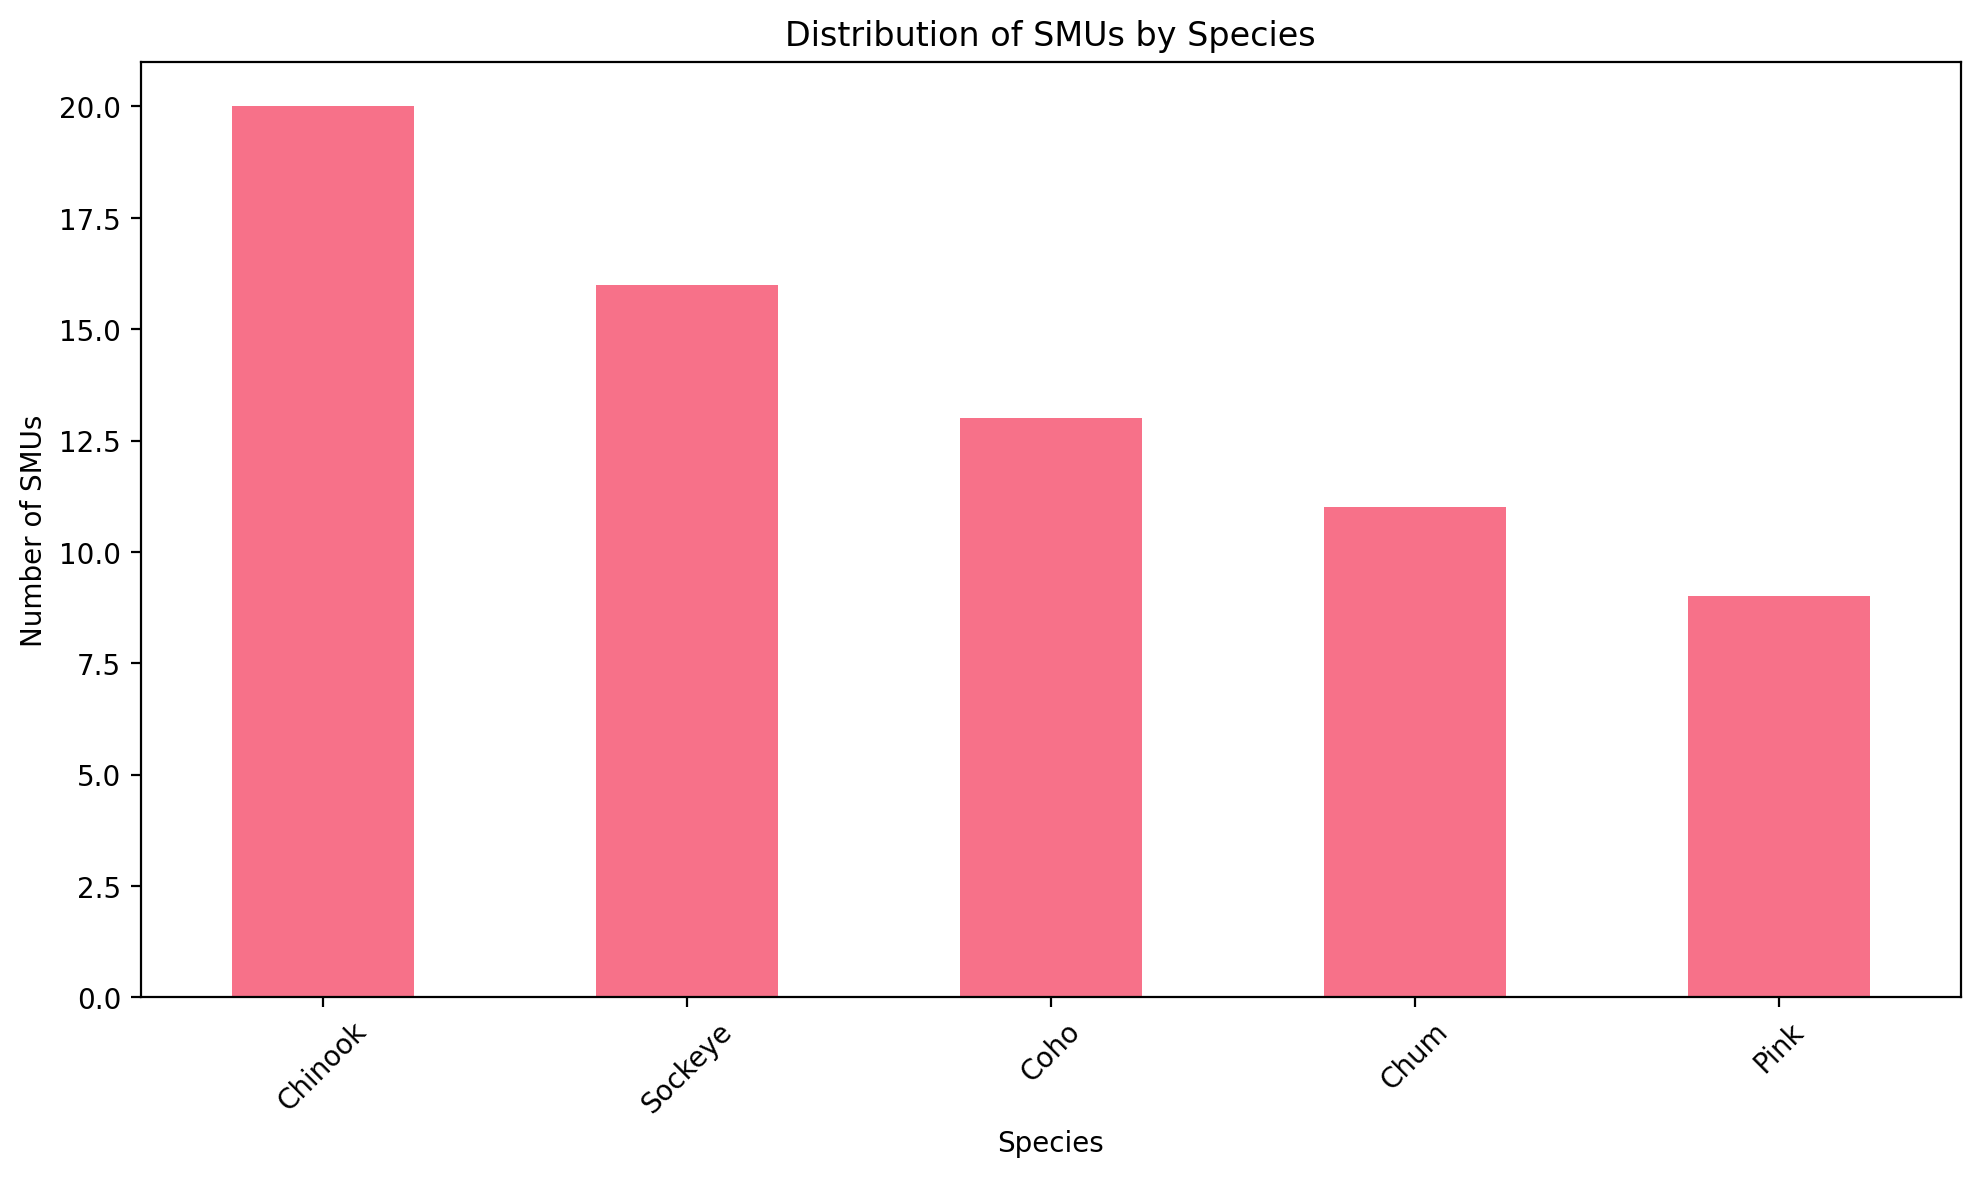

In [8]:
if not df.empty:
    # Create summary visualizations if possible
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Species distribution
    if 'Species' in df.columns:
        fig, ax = plt.subplots(figsize=(10, 6))
        species_counts = df['Species'].value_counts()
        species_counts.plot(kind='bar', ax=ax)
        ax.set_title('Distribution of SMUs by Species')
        ax.set_xlabel('Species')
        ax.set_ylabel('Number of SMUs')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    # Status distribution if available
    status_col = 'Status / Trend (last assessment)'
    if status_col in df.columns:
        status_counts = df[status_col].value_counts()
        if len(status_counts) > 1:
            fig, ax = plt.subplots(figsize=(8, 6))
            status_counts.plot(kind='pie', ax=ax, autopct='%1.1f%%')
            ax.set_title('SMU Status Distribution')
            ax.set_ylabel('')
            plt.tight_layout()
            plt.show()